# 剪枝时机

In [7]:
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F

# 设置 matplotlib 使用支持负号的字体
plt.rcParams['font.family'] = 'DejaVu Sans'

In [8]:
# 定义一个LeNet网络
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=16 * 4 * 4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=num_classes)

    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))

        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device=device)

## 1.训练后剪枝
训练后剪枝基本思想是先训练一个模型 ，然后对模型进行剪枝，最后对剪枝后模型进行微调。基本思想是通过在训练完成后移除网络中不重要的连接来减少模型的大小和计算需求。

In [9]:
# 加载之前模型剪枝后的状态字典
checkpoint = torch.load('./model_pruned.pt')
# 加载状态字典到模型
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [10]:
# 绘制权重分布图
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(2,3, figsize=(10, 6))

    # 删除多余的子图（我们只需要5个子图）
    fig.delaxes(axes[1][2])
    
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True, 
                        color = 'green', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True, 
                        color = 'green', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

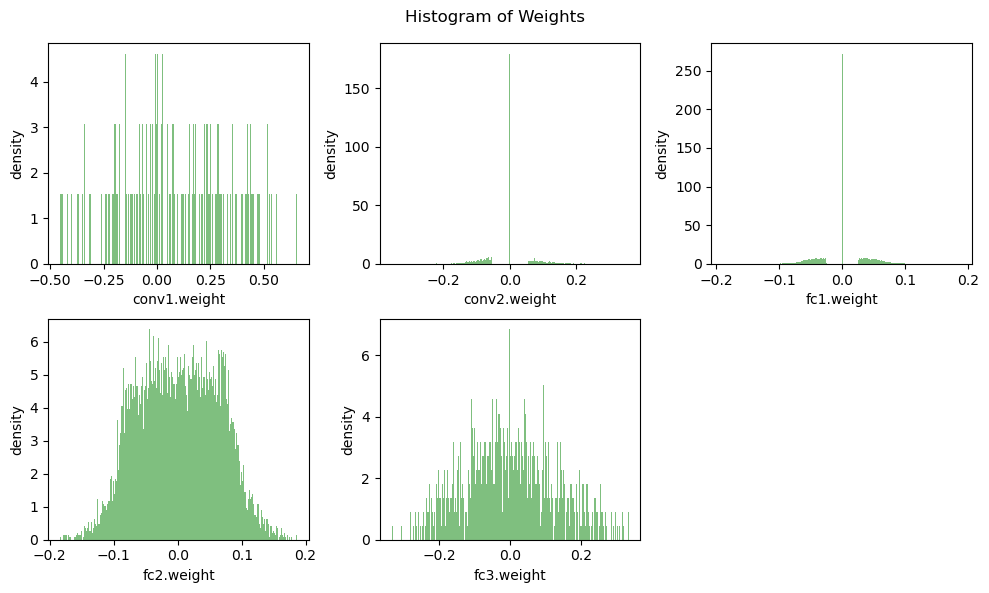

In [11]:
# 绘制weight直方图
plot_weight_distribution(model)

In [12]:

# 计算每一层网络的稠密程度
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    num_nonzeros, num_elements = 0, 0
    for name,param in model.named_parameters():
        if param.dim() > 1:
            num_nonzeros = param.count_nonzero()
            num_elements = param.numel()
            dense = float(num_nonzeros) / num_elements
            num_parameters[name] = dense
    # for name, param in model.named_parameters():
    #     if param.dim() > 1:
    #         num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(8, 6))
    plt.grid(axis='y')
    
    bars = plt.bar(list(num_parameters.keys()), list(num_parameters.values()))

    # 在柱状图上添加数据标签
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, yval, va='bottom')  # va='bottom' 使得文本在柱状图上方

    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

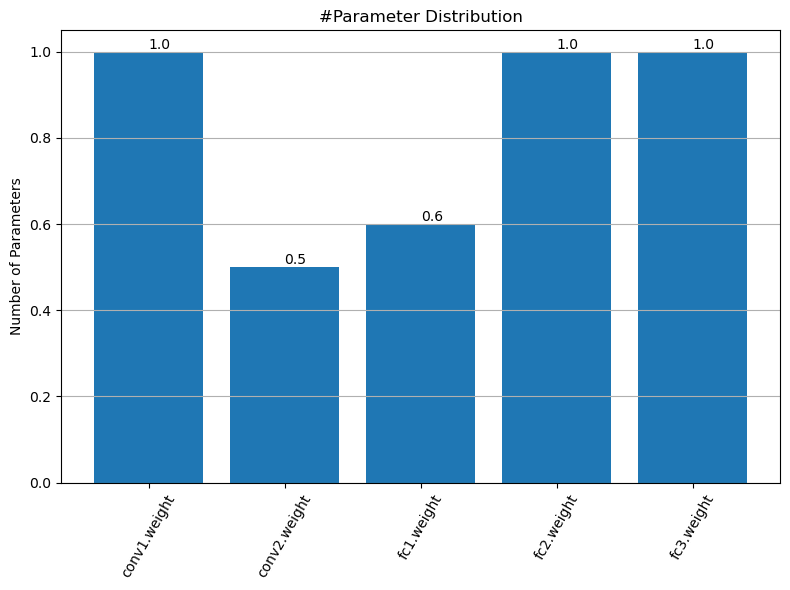

In [13]:
# 列出weight分布图
plot_num_parameters_distribution(model)

In [19]:
# 设置归一化
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# 获取数据集
train_dataset = datasets.MNIST(root='../ch02/data/mnist', train=True, download=True, transform=transform)  
test_dataset = datasets.MNIST(root='../ch02/data/mnist', train=False, download=True, transform=transform)  # train=True训练集，=False测试集

# 设置DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss()  # 交叉熵损失
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)  # lr学习率，momentum冲量

def test():
    correct = 0
    total = 0
    with torch.no_grad():  # 测试集不用算梯度
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)  # dim = 1 列是第0个维度，行是第1个维度，沿着行(第1个维度)去找1.最大值和2.最大值的下标
            total += labels.size(0)  # 张量之间的比较运算
            correct += (predicted == labels).sum().item()
    acc = correct / total
    print('[%d / %d]: Accuracy on test set: %.1f %% ' % (epoch+1, EPOCH, 100 * acc))  # 求测试的准确率，正确数/总数
    return acc

In [20]:
# 测试模型剪枝后的性能
test()

[10 / 10]: Accuracy on test set: 97.9 % 


0.9793

In [21]:
# 设置超参数
batch_size = 64
# 微调设置较低的学习率
learning_rate = 0.0001
momentum = 0.005
EPOCH = 10

In [22]:
def train(epoch):
    running_loss = 0.0  # 这整个epoch的loss清零
    running_total = 0
    running_correct = 0
    # 创建一个字典来保存梯度
    gradients = {}
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, target = data
        optimizer.zero_grad()

        # forward + backward + update
        outputs = model(inputs)
        loss = criterion(outputs, target)

        loss.backward()

        optimizer.step()

        # 把运行中的loss累加起来，为了下面300次一除
        running_loss += loss.item()
        # 把运行中的准确率acc算出来
        _, predicted = torch.max(outputs.data, dim=1)
        running_total += inputs.shape[0]
        running_correct += (predicted == target).sum().item()

        if batch_idx % 300 == 299:  # 不想要每一次都出loss，浪费时间，选择每300次出一个平均损失,和准确率
            print('[%d, %5d]: loss: %.3f , acc: %.2f %%'
                  % (epoch + 1, batch_idx + 1, running_loss / 300, 100 * running_correct / running_total))
            running_loss = 0.0  # 这小批300的loss清零
            running_total = 0
            running_correct = 0  # 这小批300的acc清零

[1,   300]: loss: 0.016 , acc: 99.51 %
[1,   600]: loss: 0.017 , acc: 99.43 %
[1,   900]: loss: 0.019 , acc: 99.36 %
[1 / 10]: Accuracy on test set: 98.8 % 
[2,   300]: loss: 0.011 , acc: 99.64 %
[2,   600]: loss: 0.016 , acc: 99.44 %
[2,   900]: loss: 0.016 , acc: 99.47 %
[2 / 10]: Accuracy on test set: 98.9 % 
[3,   300]: loss: 0.011 , acc: 99.68 %
[3,   600]: loss: 0.014 , acc: 99.55 %
[3,   900]: loss: 0.014 , acc: 99.57 %
[3 / 10]: Accuracy on test set: 99.0 % 
[4,   300]: loss: 0.011 , acc: 99.62 %
[4,   600]: loss: 0.012 , acc: 99.61 %
[4,   900]: loss: 0.013 , acc: 99.66 %
[4 / 10]: Accuracy on test set: 98.9 % 
[5,   300]: loss: 0.010 , acc: 99.63 %
[5,   600]: loss: 0.015 , acc: 99.49 %
[5,   900]: loss: 0.013 , acc: 99.58 %
[5 / 10]: Accuracy on test set: 98.9 % 
[6,   300]: loss: 0.009 , acc: 99.74 %
[6,   600]: loss: 0.011 , acc: 99.71 %
[6,   900]: loss: 0.010 , acc: 99.69 %
[6 / 10]: Accuracy on test set: 98.9 % 
[7,   300]: loss: 0.008 , acc: 99.78 %
[7,   600]: loss: 0

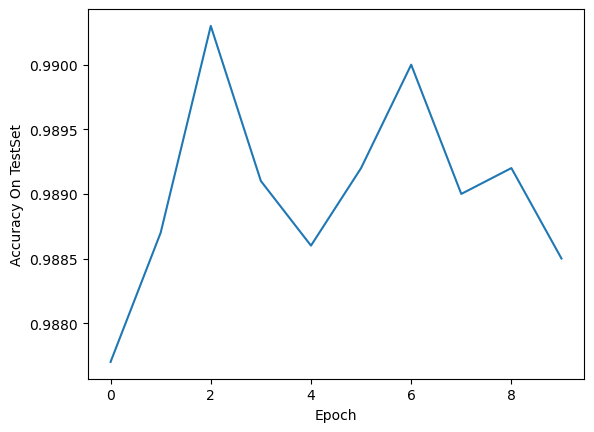

In [23]:
if __name__ == '__main__':
    acc_list_test = []
    for epoch in range(EPOCH):
        train(epoch)
        acc_test = test()
        acc_list_test.append(acc_test)

    plt.plot(acc_list_test)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy On TestSet')
    plt.show()

经过微调之后，weights发生了哪些变化呢？可以思考一下

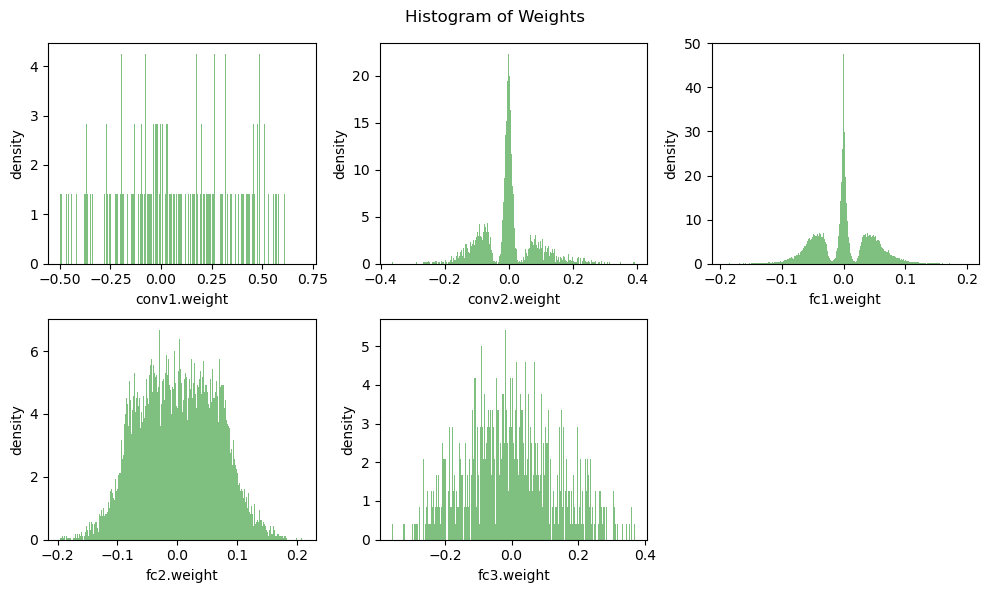

In [26]:
# 绘制weight直方图
plot_weight_distribution(model)

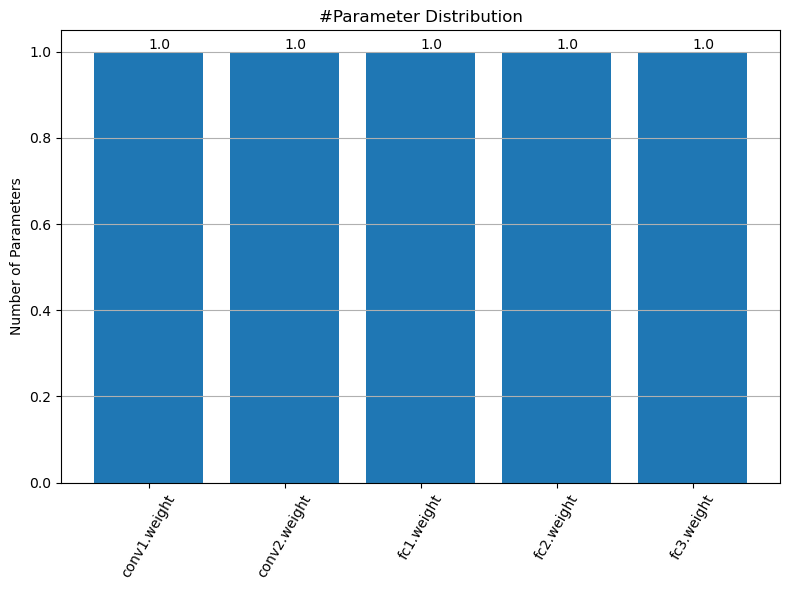

In [27]:
# 列出weight分布图
plot_num_parameters_distribution(model)

## 训练时剪枝
训练时剪枝基本思想是直接在模型训练过程中进行剪枝，最后对剪枝后模型进行微调。

In [40]:
# 设置超参数
batch_size = 64
learning_rate = 0.01
momentum = 0.5
EPOCH = 10

# 设置归一化
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# 获取数据集，True为训练集，False为测试集
train_dataset = datasets.MNIST(root='../ch02/data/mnist', train=True, download=True, transform=transform)  
test_dataset = datasets.MNIST(root='../ch02/data/mnist', train=False, download=True, transform=transform)  

# 设置DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)  

# 定义一个LeNet网络
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=16 * 4 * 4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=num_classes)

    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))

        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device=device)

def train(epoch):
    running_loss = 0.0  
    running_total = 0
    running_correct = 0

    for batch_idx, data in enumerate(train_loader, 0):
        inputs, target = data
        optimizer.zero_grad()

        # forward + backward + update
        outputs = model(inputs)
        loss = criterion(outputs, target)

        loss.backward()
        optimizer.step()

        # 把运行中的loss累加起来，为了下面300次一除
        running_loss += loss.item()
        # 把运行中的准确率acc算出来
        _, predicted = torch.max(outputs.data, dim=1)
        running_total += inputs.shape[0]
        running_correct += (predicted == target).sum().item()

        if batch_idx % 300 == 299:  # 不想要每一次都出loss，浪费时间，选择每300次出一个平均损失,和准确率
            print('[%d, %5d]: loss: %.3f , acc: %.2f %%'
                  % (epoch + 1, batch_idx + 1, running_loss / 300, 100 * running_correct / running_total))
            running_loss = 0.0  # 这小批300的loss清零
            running_total = 0
            running_correct = 0  # 这小批300的acc清零
        # 在每个epoch结束时仅对conv2的weight剪枝
        prune_conv2_l1(model, percentile=0.1)
        
        # 在每个epoch结束时对每层的weight剪枝
        # prune_l1(model, percentile=0.1)


def prune_weight_l1(weight, percentile=0.1):
    num_elements = weight.numel()

    # 计算值为0的数量
    num_zeros = round(num_elements * percentile)
    # 计算weight的重要性（使用L2范数，即各元素的平方）
    importance = weight.abs()
    # 计算裁剪阈值
    threshold = importance.view(-1).kthvalue(num_zeros).values
    # 计算mask
    mask = torch.gt(importance, threshold)
    
    # 计算mask后的weight
    weight.mul_(mask)
    return weight

def prune_conv2_l1(model, percentile=0.1):
    """
    仅对conv2层都做裁剪
    """
    model.conv2.weight.data = prune_weight_l1(model.conv2.weight.data, percentile=percentile)
    return model

def prune_l1(model, percentile=0.1):
    """
    对每个层都做剪枝
    """
    for name, param in model.named_parameters():
        if "weight" in name:
            param.data = prune_weight_l1(weight=param.data, percentile=percentile)
    return model

[1,   300]: loss: 2.300 , acc: 9.68 %
[1,   600]: loss: 2.299 , acc: 10.04 %
[1,   900]: loss: 2.299 , acc: 10.02 %
[1 / 10]: Accuracy on test set: 10.1 % 
[2,   300]: loss: 2.299 , acc: 10.04 %
[2,   600]: loss: 2.300 , acc: 9.88 %
[2,   900]: loss: 2.299 , acc: 9.86 %
[2 / 10]: Accuracy on test set: 10.1 % 
[3,   300]: loss: 2.300 , acc: 9.84 %
[3,   600]: loss: 2.298 , acc: 10.07 %
[3,   900]: loss: 2.300 , acc: 9.77 %
[3 / 10]: Accuracy on test set: 10.1 % 
[4,   300]: loss: 2.300 , acc: 9.36 %
[4,   600]: loss: 2.299 , acc: 10.02 %
[4,   900]: loss: 2.299 , acc: 10.27 %
[4 / 10]: Accuracy on test set: 10.1 % 
[5,   300]: loss: 2.300 , acc: 9.89 %
[5,   600]: loss: 2.300 , acc: 9.70 %
[5,   900]: loss: 2.298 , acc: 10.23 %
[5 / 10]: Accuracy on test set: 10.1 % 
[6,   300]: loss: 2.299 , acc: 9.73 %
[6,   600]: loss: 2.299 , acc: 10.02 %
[6,   900]: loss: 2.300 , acc: 9.97 %
[6 / 10]: Accuracy on test set: 10.1 % 
[7,   300]: loss: 2.300 , acc: 9.67 %
[7,   600]: loss: 2.299 , acc:

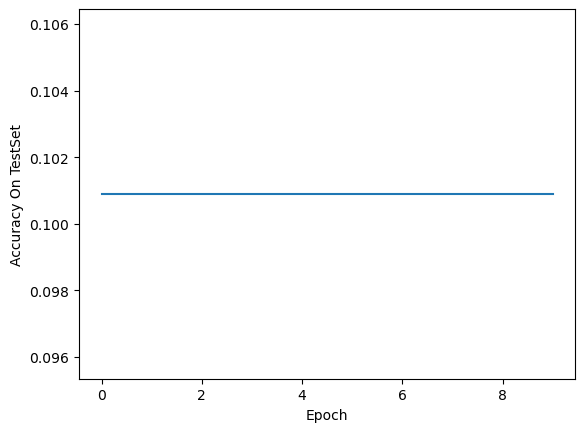

In [41]:
if __name__ == '__main__':
    acc_list_test = []
    for epoch in range(EPOCH):
        train(epoch)
        acc_test = test()
        acc_list_test.append(acc_test)

    plt.plot(acc_list_test)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy On TestSet')
    plt.show()

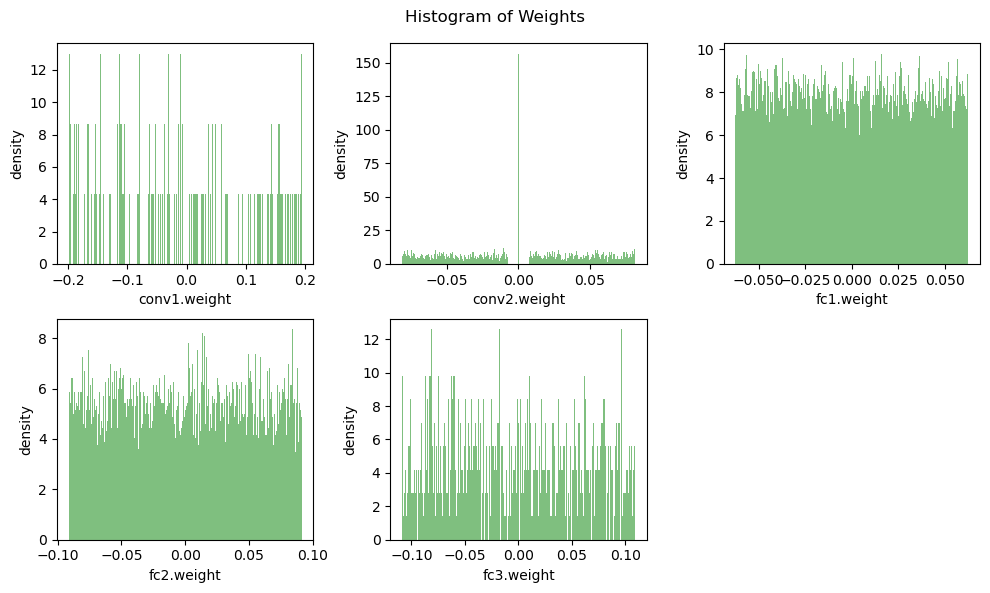

In [42]:
# 绘制weight直方图
plot_weight_distribution(model)

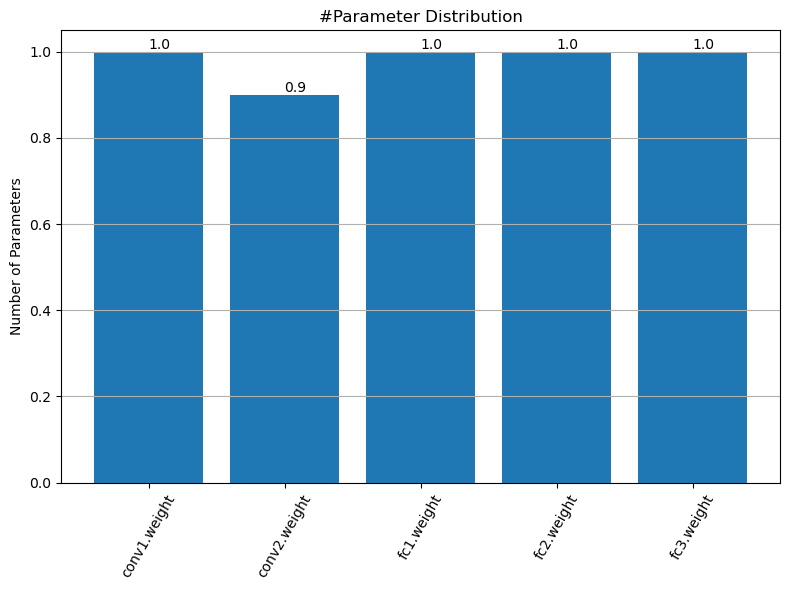

In [43]:
# 列出weight分布图
plot_num_parameters_distribution(model)